**Import Modules**

In [1]:
import os
import sys
## make paths above 'notebooks/' visible for local imports.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd 
from typing import Union
print(f"using numpy v{np.__version__}.")
print(f"using pandas v{pd.__version__}.")

from catops.catops.utils import *
# from catops.catops.cleanEvs import *
from catops.catops.cleanamps import *
from catops.catops.plotting import *
import matplotlib.pyplot as plt
from plotconf import matsettings




using numpy v1.19.4.
using pandas v1.1.5.


/opt/anaconda3/envs/YPML/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## ProcureAmpDatabase
### A notebook to combine, clean and prepare Yellowstone p-p amplitude catalogs.
The data pipeline first requires merging two csv files containing event information from pre- and post-2012 UUSS yellowstone earthquakes. The UUSS migrated their database in 2012 causing some issues when pulling pre-2012 data. It requires the data to be pulled separately for the pre- and post-migration timeframes. Monique Holt (Ph.D. candidate @ UUSS) created a shell script to query the UUSS's internal Oracle (SQL) databases for the amplitude-level information. 
 Here, we use the original pre-2012/09/30 legacy csv file (created in May, 2019) and a new (2012/10/01 to 2020/06/01) file pulled in Dec, 2020. <br>
 

There are several phases required to clean this table of data to the standards that are outlined in in Holt et al. (in prep) and Chapter 3 of my Ph.D. thesis [(Holt, 2019)](https://livrepository.liverpool.ac.uk/3064483/1/200880943_Sep2019.pdf). Here and breifly, the phases are summarised as; (1) cleaning table formatting (2) apply simple amplitude screening, (3) apply advanced amplitude screening. In between each phase we inspect the catalog and also carefully scrutinise differences with sanity checks. The advanced screening will require close attention as constants might need to change if the initial input catalog is changed. We also need to prepare a database of p-p amplitudes for the Moment Magnitude ($M_w$) catalog. The amplitudes from events that are assingned $M_w$ have trustworthy magnitudes as those is used to


**A brief note on legacy data and the new data compatibility:** <br>
The base catalog used to pull amplitudes is in /utahnet/Eqcatalogs/YELLOWSTONEeq.catalog on the UUSS servers. This catalog has all depths relative to sea level for the legacy and current-format data, the legacy data were relocated using the same velocity model as the current-format data (Pechmann, *personal comms.*). This means that **to correct to the surface datum in Yellowstone**, you simply **add 2 km to the all of the depths for all of the events**.

Global variables.

In [2]:
# PDIR = "/uufs/chpc.utah.edu/common/home/koper-group2/jholt/Yellowstone/Local_Magnitude_Study/Non_Parametric_Inversion"
PDIR = ".."
## paths
legacyFormatDataPath=f"{PDIR}/catalogs/amplitudes/amps.Yellowstone.legacydata.csv"
## to 2020/06/01
currentFormatDataPath=f"{PDIR}/catalogs/amplitudes/amps.Y2012G.csv"
## MT Mw Catalog
mtmwPath = f"{PDIR}/catalogs/events/MTCAT.csv"
## dataframes
legacy=pd.read_csv(legacyFormatDataPath)
current=pd.read_csv(currentFormatDataPath)
mtmw=pd.read_csv(mtmwPath)

Playground to test functions .


Merge legacy- and current-format data tables and clear basic formatting issues.The basic issues are explained in each sub-function called by clear_issues.

In [3]:
## be mindful of the order that these functions are used to clean the dataframe
cleaning_funcs = (fill_legacy_snr, convert_cm_to_mm, remove_snr_below_thresh,
                  clean_comp_cols, remove_nan_amp_rows, create_mean_half_pp_amp_col, 
                  reduce_to_single_instrument_per_event, create_catalog_magnitude_col, 
                  adjust_depth_to_average_elevation, create_focal_dep_dmin_ratio_col, 
                  add_focal_depth_quality_col, remove_mixed_station_meta_rows)

total = concat_dataframes(legacy, current); clear_issues(total, cleaning_funcs); # bit of a cheap one-liner
total_backup = total.copy(deep=True)
print_catalog_stats(total)

/opt/anaconda3/envs/YPML/lib/python3.8/site-packages/obspy/core/inventory/network.py:324: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


The catalog contains 31545 amplitudes from 7684 earthquakes.


## In this phase we can begin our initial screening of amplitudes. <br>
We apply the following rules for p-p amplitudes: <br>
1. Hypocentral Distance ($R_{hyp}$) $\leq$ 180 km - done
2. Amplitudes must come from events with a good focal-depth constraint if they are recorded $R_{epi}$<50 km 
3. Difference between N-S and E-W log10(p-p) must be < 4 standard deviations
4. Amplitudes only from events that have at least three recorded at unique locations 


## 1. Hypocentral distance screening
First, inspect the magnitude-distance distribution on our format 'clean' catalog.

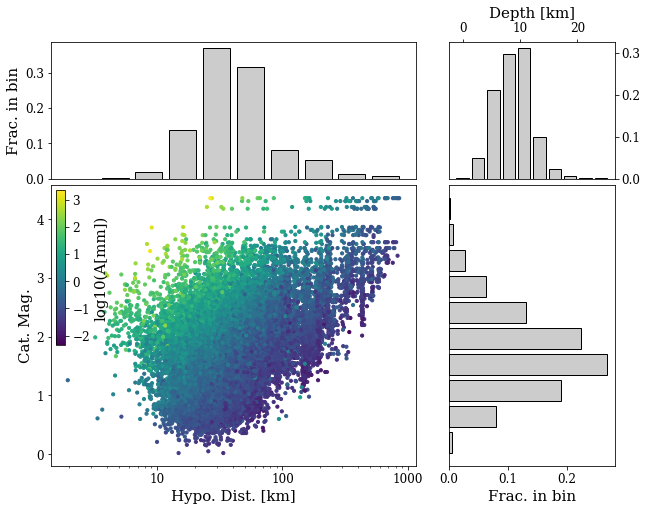

In [4]:
save_str = "../figures/initial-mag-distance-amp-distribution-no-filters.pdf"
quick_inspect_magnitude_distance(total, save=save_str)


## Some expert judgement applies...
We utilise our knowledge of station distribution inside and outside Yellowstone to pick this distance. Only 4 stations on the fringes of this range have highly repeating paths, but we have station corrections (that we mostly trust) for all of them.
Therefore, we pick $R_{hyp}$=180 km based on this understanding and the fact that beyond that distance the mag-distance distribution becomes very narrow.
We also wanted to make sure that we had a big enough distance range to adequately estimate $M_L$ for the larger (M>3) events which tend to be better recorded at farther distances. 

The catalog contains 30114 amplitudes from 7672 earthquakes.


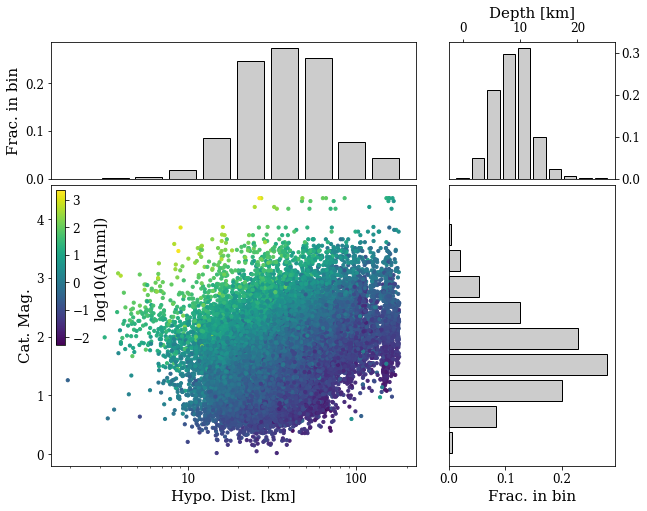

In [5]:
total = total[total.Rhyp <= 180]
save_str = "../figures/180km-mag-distance-amp-distribution-distance-filter-only.pdf"
quick_inspect_magnitude_distance(total, save=save_str)
print_catalog_stats(total)


## 2. Remove amplitudes recorded $R_{epi}$<50 km for events with poor focal depths

In [6]:
total = remove_near_amps_w_bad_focal_dep(total)

The catalog contains 25920 amplitudes from 6594 earthquakes.


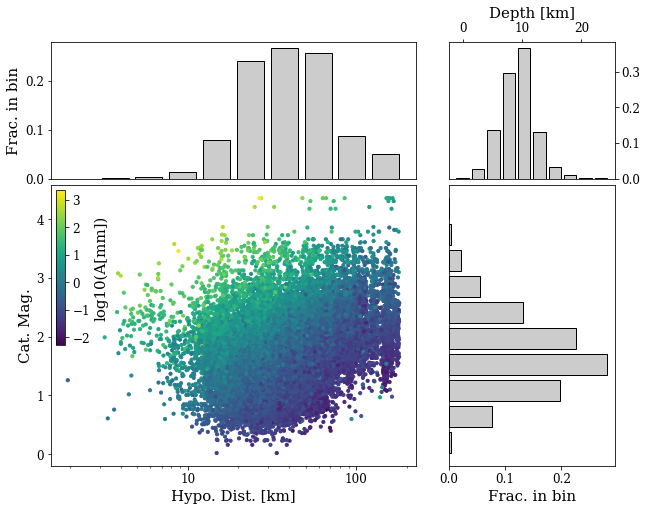

In [7]:
save_str = "../figures/180km-mag-distance-amp-distribution+focal-depth-constraint.pdf"
quick_inspect_magnitude_distance(total, save=save_str)
print_catalog_stats(total)


## 3. Difference between N-S and E-W $log_{10}$[p-p] must be < 4 standard deviations

In this phase, we inspect the amplitudes to look for other potential data errors outside of our chosen criteria. We note that there are some outlying data points where the difference between N-S and E-W $log_{10}$[p-p] ($\Delta$ $log_{10}$[p-p]) is large at some stations. It looks like 4 standard deviations from the mean is good justification for removing outliers. It looks well beyond the nice normal distribution the bulk $\Delta$ $log_{10}$[p-p] make. Use this value to remove outlier amplitudes.

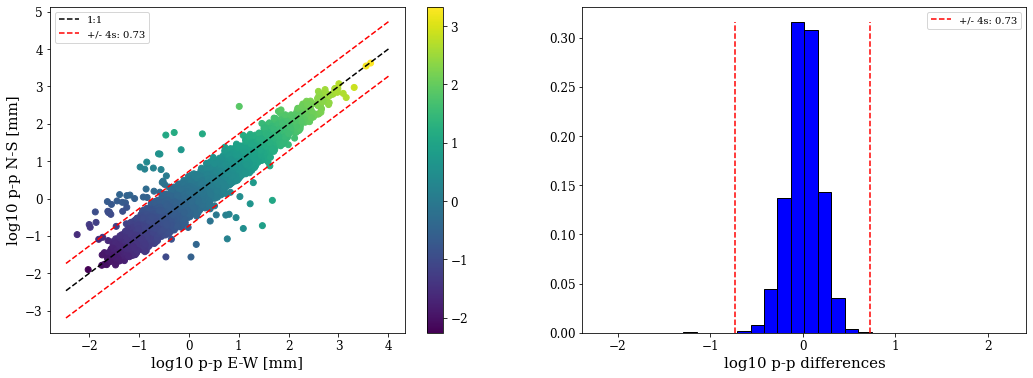

In [8]:
quick_inspect_amplitudes(total['AmpE'].apply(np.log10).values, 
                         total['AmpN'].apply(np.log10).values, 
                         C=total['halfAmpH'].apply(np.log10).values, 
                         s=4)

Functions that clean data but require data inspection for guidance. 

In [9]:
total_cut = cut_outlier_amps_on_difference(total, 0.77)

Looks like 4 standard deviations did the trick!

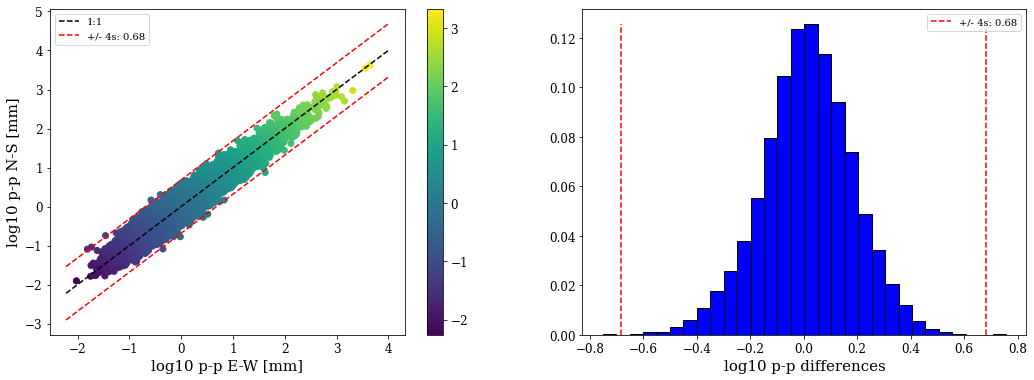

In [10]:
quick_inspect_amplitudes(total_cut['AmpE'].apply(np.log10).values, 
                         total_cut['AmpN'].apply(np.log10).values, 
                         C=total_cut['halfAmpH'].apply(np.log10).values, 
                         s=4)

What's the difference?

In [11]:
diff = dataframe_difference(total, total_cut)[['Evid', 'Net', 'Sta', 'AmpE', 'AmpN']]
print(f"removed {len(diff)} out of {len(total)}")
total = total_cut # assign total_cut to total so we can continue as before

removed 55 out of 25920


The catalog contains 25865 amplitudes from 6593 earthquakes.


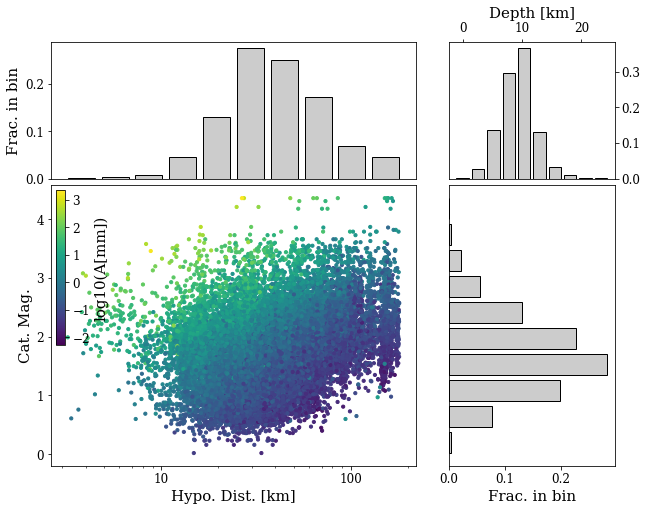

In [12]:
save_str = "../figures/180km-mag-distance-amp-distribution+focal-depth-constraint+std-dv-cut.pdf"
quick_inspect_magnitude_distance(total, save=save_str)
print_catalog_stats(total)

## 4. Amplitudes only from events that have at least three from unique stations/sites

The catalog contains 25491 amplitudes from 6219 earthquakes.


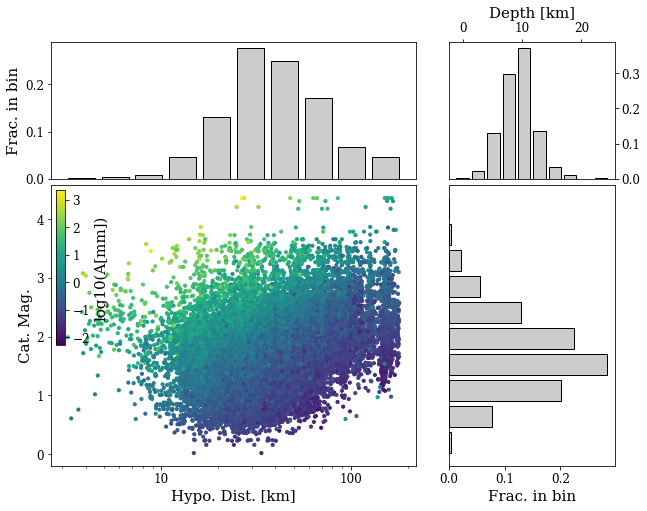

In [13]:
total = cut_events_below_min_amp_count_thresh(total)
save_str = "../figures/180km-mag-distance-amp-distribution+focal-depth-constraint+std-dv-cut-min-event-threshold.pdf"
quick_inspect_magnitude_distance(total, save=save_str)
print_catalog_stats(total)

Now that the p-p amplitudes are 'clean' we have a set of candidate events with the best quality data to choose from. This catalog is now ready to be balanced geographically, so we don't overload any ray paths. We have to do this because of the clustered and 'swarmy' nature of the Yellowstone events. We export the clean catalog of amplitudes and a catalog of just the events and locations to help us in the next phase. 

In [14]:
## save quality amplitudes
total.to_csv(f"{PDIR}/catalogs/amplitudes/yellowstone.amps.clean.csv", index=False)


In [15]:
## save catalog of candidate events for geographic balancing 
candid_cat = total.drop_duplicates("Evid").reset_index(drop=True)

In [16]:
count = total.groupby("Evid").size()
candid_cat.loc[candid_cat["Evid"] == count.index, "Namps"] = count.values
candid_cat[["Evid", "EqLon", "EqLat", "EqDep", "CatMag", "Namps"]].to_csv(f"{PDIR}/catalogs/events/yellowstone.events.clean.csv", index=False)
